In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string as Str
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss,confusion_matrix,accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier
from scipy.sparse import csr
from scipy.sparse import hstack

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict

from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
#from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression


In [2]:
data = pd.read_csv("training_variants")
print("Number of data points :" ,data.shape[0])
print("Number of features :",data.shape[1])
print("Features :" ,data.columns.values)
data.head()

Number of data points : 3321
Number of features : 4
Features : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
data_text = pd.read_csv("training_text" , sep = "\|\|",engine = "python" , names = ["ID","TEXT"] , skiprows = 1)
print("Nummber of data points: ",data.shape[0])
print("Number of Features: ",data.shape[1])
print("Features :",data.columns.values)
data.head()
data.head()

Nummber of data points:  3321
Number of Features:  4
Features : ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
stop_words = set(stopwords.words("english"))

In [5]:
def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string = ""
    
    total_text = re.sub('[^a-zA-Z0-9\n]',' ',total_text)
    
    total_text = re.sub('\s+',' ',total_text)
    
    total_text = total_text.lower()
    
    for word in total_text.split():
        if word not in stop_words:
            string+= word + " "
            
    data_text[column][index] = string
    

In [6]:
for index,row in data_text.iterrows():
    if type(row['TEXT']) == str:
        nlp_preprocessing(row['TEXT'] , index , 'TEXT' )
    else:
        print("There is no text description for id :" , index)

    

<ipython-input-5-8f7561b6ae40>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_text[column][index] = string


There is no text description for id : 1109
There is no text description for id : 1277
There is no text description for id : 1407
There is no text description for id : 1639
There is no text description for id : 2755


In [7]:
#merging both gene_variations and text data based on ID
result = pd.merge(data , data_text , on = "ID" , how = "left")

In [8]:
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [9]:
result.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
TEXT         5
dtype: int64

In [10]:
#printing the null rows
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
result.loc[result["TEXT"].isnull(),'TEXT'] = result['Gene'] + ' ' + result['Variation']

In [12]:
result[result['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


## Train Test Split

In [13]:
y_true = result["Class"].values

result.Gene = result.Gene.str.replace('\s+' , '_' , regex = True)
result.Variation = result.Variation.str.replace('\s+' , '_' , regex = True)

X_train , test_df , y_train , y_test = train_test_split(result , y_true , stratify = y_true , test_size = 0.2 )

#cross validation
train_df , cv_df , y_train , y_cv = train_test_split(X_train , y_train , stratify = y_train , test_size = 0.2)



#### We split the data into train, test and cross validation data sets, preserving the ratio of class distribution in the original data set

In [14]:
print("NUmber of data points in train data :{}\nThe number of data points in test data:{}\nThe number of data points in cv data:{}".format(train_df.shape[0],test_df.shape[0],cv_df.shape[0]))                     

NUmber of data points in train data :2124
The number of data points in test data:665
The number of data points in cv data:532


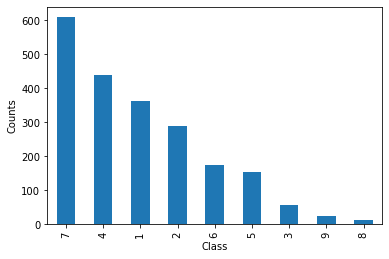

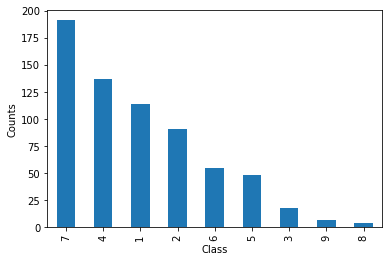

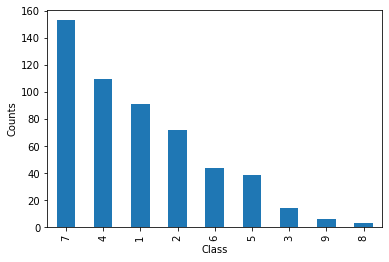

In [15]:
plt.subplot(1,1,1)
train_df['Class'].value_counts().plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

test_df['Class'].value_counts().plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

cv_df['Class'].value_counts().plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.show()

##### we are working on imbalanced data

## Random classifier

##### I built a random classifier just so to compare my results with the more intelligent classifier that I will be building next

In [16]:


dummy_clf = DummyClassifier(strategy = 'uniform')
dummy_clf.fit(train_df,y_train)
prob_preds = dummy_clf.predict_proba(cv_df)
preds = dummy_clf.predict(cv_df)
print('log loss for cross validation data : {}'.format(log_loss(y_cv , prob_preds , eps = 1e-15)))






log loss for cross validation data : 2.1972245773362196


## Univariate analysis

#### GENE

In [17]:
unique_genes = train_df['Gene'].value_counts()
print(unique_genes)
print('the number of distinct genes are :' , unique_genes.shape[0])

BRCA1    172
TP53      96
EGFR      92
BRCA2     81
PTEN      78
        ... 
ETV1       1
BARD1      1
IKZF1      1
ASXL1      1
AXIN1      1
Name: Gene, Length: 235, dtype: int64
the number of distinct genes are : 235


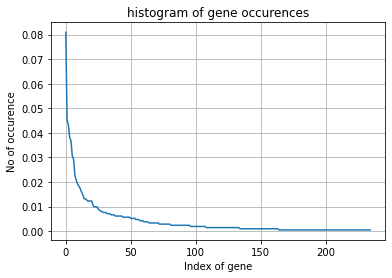

In [18]:
s = sum(unique_genes.values)
h = unique_genes.values/s
plt.plot(h)
plt.title('histogram of gene occurences')
plt.xlabel('Index of gene')
plt.ylabel('No of occurence')
plt.grid()
plt.show()

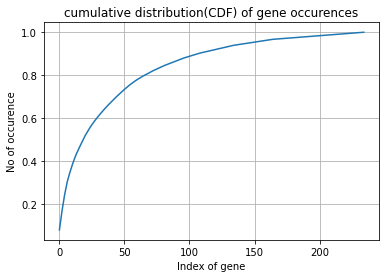

In [19]:
plt.plot(np.cumsum(h))
plt.title('cumulative distribution(CDF) of gene occurences')
plt.xlabel('Index of gene')
plt.ylabel('No of occurence')
plt.grid()
plt.show()

In [20]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']
# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+90*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

# get_gv_fea_dict: Get Gene varaition Feature Dict
def get_gv_fea_dict(alpha, feature, df):
    # value_count: it contains a dict like
    # print(train_df['Gene'].value_counts())
    # output:
    #        {BRCA1      174
    #         TP53       106
    #         EGFR        86
    #         BRCA2       75
    #         PTEN        69
    #         KIT         61
    #         BRAF        60
    #         ERBB2       47
    #         PDGFRA      46
    #         ...}
    # print(train_df['Variation'].value_counts())
    # output:
    # {
    # Truncating_Mutations                     63
    # Deletion                                 43
    # Amplification                            43
    # Fusions                                  22
    # Overexpression                            3
    # E17K                                      3
    # Q61L                                      3
    # S222D                                     2
    # P130S                                     2
    # ...
    # }
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi==1/Gi) probability of gene/variation belongs to perticular class
        # vec is 9 diamensional vector
        vec = []
        for k in range(1,10):
            # print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
            #         ID   Gene             Variation  Class  
            # 2470  2470  BRCA1                S1715C      1   
            # 2486  2486  BRCA1                S1841R      1   
            # 2614  2614  BRCA1                   M1R      1   
            # 2432  2432  BRCA1                L1657P      1   
            # 2567  2567  BRCA1                T1685A      1   
            # 2583  2583  BRCA1                E1660G      1   
            # 2634  2634  BRCA1                W1718L      1   
            # cls_cnt.shape[0] will return the number of rows

            cls_cnt = train_df.loc[(train_df[feature]==i) & (train_df['Class']==k) ]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occured in whole data
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))

        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    # print(gv_dict)
    #     {'BRCA1': [0.20075757575757575, 0.03787878787878788, 0.068181818181818177, 0.13636363636363635, 0.25, 0.19318181818181818, 0.03787878787878788, 0.03787878787878788, 0.03787878787878788], 
    #      'TP53': [0.32142857142857145, 0.061224489795918366, 0.061224489795918366, 0.27040816326530615, 0.061224489795918366, 0.066326530612244902, 0.051020408163265307, 0.051020408163265307, 0.056122448979591837], 
    #      'EGFR': [0.056818181818181816, 0.21590909090909091, 0.0625, 0.068181818181818177, 0.068181818181818177, 0.0625, 0.34659090909090912, 0.0625, 0.056818181818181816], 
    #      'BRCA2': [0.13333333333333333, 0.060606060606060608, 0.060606060606060608, 0.078787878787878782, 0.1393939393939394, 0.34545454545454546, 0.060606060606060608, 0.060606060606060608, 0.060606060606060608], 
    #      'PTEN': [0.069182389937106917, 0.062893081761006289, 0.069182389937106917, 0.46540880503144655, 0.075471698113207544, 0.062893081761006289, 0.069182389937106917, 0.062893081761006289, 0.062893081761006289], 
    #      'KIT': [0.066225165562913912, 0.25165562913907286, 0.072847682119205295, 0.072847682119205295, 0.066225165562913912, 0.066225165562913912, 0.27152317880794702, 0.066225165562913912, 0.066225165562913912], 
    #      'BRAF': [0.066666666666666666, 0.17999999999999999, 0.073333333333333334, 0.073333333333333334, 0.093333333333333338, 0.080000000000000002, 0.29999999999999999, 0.066666666666666666, 0.066666666666666666],
    #      ...
    #     }
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each feature value in the data
    gv_fea = []
    # for every feature values in the given data frame we will check if it is there in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
#             gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
    return gv_fea

In [21]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [22]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


### one hot encoding

In [23]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotcoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotcoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotcoding = gene_vectorizer.transform(cv_df['Gene'])

In [24]:
train_df['Gene'].head()

1538       ALK
1962     MAPK1
547      SMAD2
2578     BRCA1
1934    CARD11
Name: Gene, dtype: object

In [25]:
gene_vectorizer.get_feature_names()

['abl1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'asxl1',
 'asxl2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'axin1',
 'b2m',
 'bap1',
 'bard1',
 'bcl10',
 'bcl2',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdk8',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'eif1ax',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc3',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf3',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxl2',
 'foxp1',
 'fubp1',
 'gata3',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r'

In [26]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotcoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 234)


In [27]:

alpha = [10**x for x in range(-5,1)]
cv_log_error_array = []


for i in alpha:
    clf = SGDClassifier(alpha = i , penalty = 'l2' , loss = 'log' , random_state = 42)
    clf.fit(train_gene_feature_onehotcoding , y_train)
    sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid' )
    sig_clf.fit(train_gene_feature_onehotcoding ,y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotcoding)
    cv_log_error_array.append(log_loss(y_cv , predict_y , labels = clf.classes_ , eps = 1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
#   train_df , cv_df , y_train , y_cv
    
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotcoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotcoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


    
    

    
    





For values of alpha =  1e-05 The log loss is: 1.221730693029873
For values of alpha =  0.0001 The log loss is: 1.2113115113453787
For values of alpha =  0.001 The log loss is: 1.2610249912213407
For values of alpha =  0.01 The log loss is: 1.3632549168448302
For values of alpha =  0.1 The log loss is: 1.4249337439312426
For values of alpha =  1 The log loss is: 1.460108199491507
For values of best alpha =  0.0001 The train log loss is: 0.988726146134888
For values of best alpha =  0.0001 The cross validation log loss is: 1.2113115113453787
For values of best alpha =  0.0001 The test log loss is: 1.1716084460337672


#### Here our log loss is significantly less than that of a random model so it means that the gene feature with one hot encoding has some weightage

## Univariate analysis on Variation feature

In [28]:
unique_variations = train_df['Variation'].value_counts()
print('the number of variations in the training dataset are :',unique_variations.shape[0])
print(unique_variations.head(10))

the number of variations in the training dataset are : 1936
Truncating_Mutations    58
Deletion                46
Amplification           44
Fusions                 21
Overexpression           4
G12V                     3
F28L                     2
Q61H                     2
Q22K                     2
I31M                     2
Name: Variation, dtype: int64


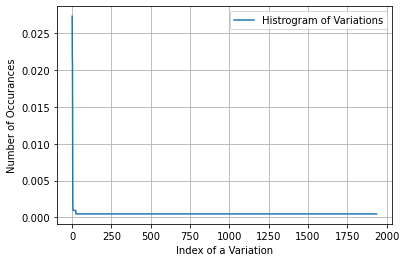

In [29]:
s = sum(unique_variations.values)
h = unique_variations.values/s
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02730697 0.04896422 0.06967985 ... 0.99905838 0.99952919 1.        ]


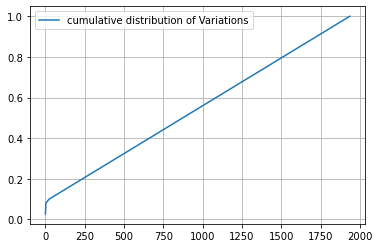

In [30]:
p = np.cumsum(h)
print(p)
plt.plot(p , label = 'cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [31]:
alpha = 1
train_variation_feature_responsecoding = np.array(get_gv_feature(alpha , 'Variation' , train_df))
test_variation_feature_responsecoding = np.array(get_gv_feature (alpha , 'Variation' , test_df))
cv_variation_feature_responsecoding = np.array(get_gv_feature(alpha , 'Variation' , cv_df))

In [32]:
print("The response coded train_df for variation has a shape of",train_variation_feature_responsecoding.shape)

The response coded train_df for variation has a shape of (2124, 9)


In [33]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotcoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotcoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotcoding = variation_vectorizer.transform(cv_df['Variation'])

In [34]:
alpha = [10**x for x in range (-5,1)]
cv_log_loss_array = []

for i in alpha:
    clf = SGDClassifier(alpha = i , penalty = 'l2' , loss = 'log' , random_state = 42)
    clf.fit(train_variation_feature_onehotcoding , y_train) 
    
    sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
    sig_clf.fit(train_variation_feature_onehotcoding , y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotcoding)
    cv_log_loss_array.append(log_loss(y_cv,predict_y ))
    print("the logg loss for {} is {} ".format(i , log_loss(y_cv , predict_y)))
    
best_alpha = np.argmin(cv_log_loss_array)

clf = SGDClassifier(alpha = alpha[best_alpha] , penalty = 'l2' , loss = 'log' , random_state = 42)
clf.fit(train_variation_feature_onehotcoding , y_train) 

sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
sig_clf.fit(train_variation_feature_onehotcoding , y_train)
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotcoding)
cv_log_loss_array.append(log_loss(y_cv,predict_y ))

predict_y = sig_clf.predict_proba(train_variation_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


the logg loss for 1e-05 is 1.6958308254175527 
the logg loss for 0.0001 is 1.6876735653921984 
the logg loss for 0.001 is 1.6912680740153494 
the logg loss for 0.01 is 1.697932246052724 
the logg loss for 0.1 is 1.7087672781902328 
the logg loss for 1 is 1.7101067342125242 
For values of best alpha =  0.0001 The train log loss is: 0.6923216129481906
For values of best alpha =  0.0001 The cross validation log loss is: 1.6876735653921984
For values of best alpha =  0.0001 The test log loss is: 1.699717068253431


In [35]:
print('how many of the data points in training dataset' ,train_df.shape[0] )
test_coverage = test_df[test_df['Variation'].isin((train_df['Variation']))].shape[0]
cv_coverage = cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)


how many of the data points in training dataset 2124
In test data 74 out of 665 : 11.12781954887218
In cross validation data 58 out of  532 : 10.902255639097744


#### our feature variation is unstable

### Univariate analysis [Text]

In [36]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    
    dictionary = defaultdict(int)
    for i,row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1
            
    return dictionary

            


In [37]:


def get_text_responsecoding(df):
    
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding
    
    
    

In [38]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)

train_text_feature_responsecoding  = get_text_responsecoding(train_df)
test_text_feature_responsecoding  = get_text_responsecoding(test_df)
cv_text_feature_responsecoding  = get_text_responsecoding(cv_df)

In [39]:
# we convert each row values such that they sum to 1  
train_text_feature_responsecoding = (train_text_feature_responsecoding.T/train_text_feature_responsecoding.sum(axis=1)).T
test_text_feature_responsecoding = (test_text_feature_responsecoding.T/test_text_feature_responsecoding.sum(axis=1)).T
cv_text_feature_responsecoding = (cv_text_feature_responsecoding.T/cv_text_feature_responsecoding.sum(axis=1)).T

In [40]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data

text_vectorizer = CountVectorizer(min_df = 3)
train_text_feature_onehotcoding = text_vectorizer.fit_transform(train_df['TEXT'])

train_text_features = text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_feature_counts = train_text_feature_onehotcoding.sum(axis = 0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
train_fea_dict = dict(zip(list(train_text_features) , train_text_feature_counts))

In [41]:
# don't forget to normalize every feature
train_text_feature_onehotcoding = normalize(train_text_feature_onehotcoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotcoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotcoding = normalize(test_text_feature_onehotcoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotcoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotcoding = normalize(cv_text_feature_onehotcoding, axis=0)

In [42]:
print('the number of unique words in the dataset are : ', len(train_text_features))

the number of unique words in the dataset are :  53090


In [43]:
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotcoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotcoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotcoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))




best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotcoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotcoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


For values of alpha =  1e-05 The log loss is: 1.3087913358685854
For values of alpha =  0.0001 The log loss is: 1.1763652348172384
For values of alpha =  0.001 The log loss is: 1.1596219974675306
For values of alpha =  0.01 The log loss is: 1.2710114935732124
For values of alpha =  0.1 The log loss is: 1.4432971756525015
For values of alpha =  1 The log loss is: 1.6276215694809208
For values of best alpha =  0.001 The train log loss is: 0.6681607569912816
For values of best alpha =  0.001 The cross validation log loss is: 1.1596219974675306
For values of best alpha =  0.001 The test log loss is: 1.1944508642774538


### These are one of the best results we've got for predicting yi's

In [44]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df = 3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()
    
    len_1 = len(set(df_text_features))
    len_2 = len(set(train_text_features) & set(df_text_features))
    return len_1,len_2

    

In [45]:
len_1,len_2 = get_intersec_text(test_df)
print(np.round((len_2/len_1)*100,3),'% of word of test data appeared in train data')
len1,len2 = get_intersec_text(cv_df)
print(np.round((len_2/len_1)*100, 3), "% of word of Cross Validation appeared in train data")


96.742 % of word of test data appeared in train data
96.742 % of word of Cross Validation appeared in train data


### Text feature is pretty stable too !

## Building ML models

In [46]:
def predict(X_train , X_test , y_train , y_test,clf):
    
    clf.fit(X_train , y_train)
    sig_clf = CalibratedClassifierCV(clf , method = 'sigmoid')
    pred = sig_clf.predict(X_test)
    
    print('log loss:' , log_loss(y_test , sig_clf.predict_proba(X_test)))
    print('Number of misclassified points' , np.count_nonzero((pred - y_test)) / y_test.shape[0])
    
    
          

    

In [47]:
def report_log_loss(X_train , X_test , y_train , y_test,clf):
    
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)
    

In [48]:
train_gene_var_onehotcoding = hstack((train_gene_feature_onehotcoding,train_variation_feature_onehotcoding))
test_gene_var_onehotcoding = hstack((test_gene_feature_onehotcoding,test_variation_feature_onehotcoding))
cv_gene_var_onehotcoding = hstack((cv_gene_feature_onehotcoding,cv_variation_feature_onehotcoding))

train_x_onehotcoding = hstack((train_gene_var_onehotcoding, train_text_feature_onehotcoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotcoding = hstack((test_gene_var_onehotcoding, test_text_feature_onehotcoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotcoding = hstack((cv_gene_var_onehotcoding, cv_text_feature_onehotcoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))



In [49]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotcoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotcoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotcoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 55291)
(number of data points * number of features) in test data =  (665, 55291)
(number of data points * number of features) in cross validation data = (532, 55291)


In [50]:
train_gene_var_responsecoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responsecoding))
test_gene_var_responsecoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responsecoding))
cv_gene_var_responsecoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responsecoding))

train_x_responsecoding = np.hstack((train_gene_var_responsecoding, train_text_feature_responsecoding))
test_x_responsecoding = np.hstack((test_gene_var_responsecoding, test_text_feature_responsecoding))
cv_x_responsecoding = np.hstack((cv_gene_var_responsecoding, cv_text_feature_responsecoding))

In [51]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responsecoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responsecoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responsecoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Baseline model (naive bayes)

In [52]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs))
    
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


for alpha = 1e-05
Log Loss : 1.2883807521150776
for alpha = 0.0001
Log Loss : 1.276882275273027
for alpha = 0.001
Log Loss : 1.2827299010225202
for alpha = 0.1
Log Loss : 1.2829061734059917
for alpha = 1
Log Loss : 1.301945736629914
for alpha = 10
Log Loss : 1.4221733789082849
for alpha = 100
Log Loss : 1.4455153093021165
for alpha = 1000
Log Loss : 1.3840294523790762
For values of best alpha =  0.0001 The train log loss is: 0.8133285507604147
For values of best alpha =  0.0001 The cross validation log loss is: 1.276882275273027
For values of best alpha =  0.0001 The test log loss is: 1.307825477710635


### the model worked fairly well ,  next I'll cal the miscalssifed points

In [53]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", (np.count_nonzero((sig_clf.predict(cv_x_onehotcoding)- cv_y))/cv_y.shape[0])*100,'%')

Log Loss : 1.276882275273027
Number of missclassified point : 40.78947368421053 %


### the percentage of miscalssified points comes to be around 37%

# Logistic regression with class balancing

In [54]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight = 'balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3597724542592624
for alpha = 1e-05
Log Loss : 1.303215749826288
for alpha = 0.0001
Log Loss : 1.1351555683931378
for alpha = 0.001
Log Loss : 1.097057130206378
for alpha = 0.01
Log Loss : 1.1629475033114938
for alpha = 0.1
Log Loss : 1.4695383713105867
for alpha = 1
Log Loss : 1.6986630227657475
for alpha = 10
Log Loss : 1.7278738535977112
for alpha = 100
Log Loss : 1.7309925135848507
For values of best alpha =  0.001 The train log loss is: 0.534857827677622
For values of best alpha =  0.001 The cross validation log loss is: 1.097057130206378
For values of best alpha =  0.001 The test log loss is: 1.1022289208203107


In [56]:
## percentage of misclassified points

clf = SGDClassifier(class_weight = 'balanced' , alpha = alpha[best_alpha] , loss = 'log' , penalty = 'l2' , random_state = 40)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)
pred = sig_clf.predict(cv_x_onehotcoding)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)

print('for best value of alpha: {} the misclassified percentile of points is : {}%'.format((alpha[best_alpha]),(np.count_nonzero((pred - cv_y))/cv_y.shape[0])*100))




for best value of alpha: 0.001 the misclassified percentile of points is : 33.83458646616541%


### the best result so far is given by logistic regression with class balancing

### Now I'll do logistic regression without class balacing just out of curiosity

In [59]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for alpha = 1e-06
Log Loss : 1.3185099027082166
for alpha = 1e-05
Log Loss : 1.2765335094751156
for alpha = 0.0001
Log Loss : 1.1615655094952646
for alpha = 0.001
Log Loss : 1.1119714615220835
for alpha = 0.01
Log Loss : 1.217751628782019
for alpha = 0.1
Log Loss : 1.3657657074395213
for alpha = 1
Log Loss : 1.575217367696662
for alpha = 10
Log Loss : 1.6145726484469571
for alpha = 100
Log Loss : 1.6190088745207312
For values of best alpha =  0.001 The train log loss is: 0.534857827677622
For values of best alpha =  0.001 The cross validation log loss is: 1.097057130206378
For values of best alpha =  0.001 The test log loss is: 1.1022289208203107


In [61]:
clf = SGDClassifier( alpha = alpha[best_alpha] , loss = 'log' , penalty = 'l2' , random_state = 40)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)
pred = sig_clf.predict(cv_x_onehotcoding)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)

print('for best value of alpha: {} the misclassified percentile of points is : {}%'.format((alpha[best_alpha]),(np.count_nonzero((pred - cv_y))/cv_y.shape[0])*100))


for best value of alpha: 0.001 the misclassified percentile of points is : 34.58646616541353%


##### It performed slightly worse than the balanced Logistic regression but it has more misclassified points which can be really Catostraphic in medical fields


## Trying out linear SVM now

In [62]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotcoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotcoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 



best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for C = 1e-05
Log Loss : 1.3424455990108595
for C = 0.0001
Log Loss : 1.224845697032574
for C = 0.001
Log Loss : 1.1223013176868444
for C = 0.01
Log Loss : 1.1305936243423438
for C = 0.1
Log Loss : 1.4190243628533448
for C = 1
Log Loss : 1.7161254776891934
for C = 10
Log Loss : 1.7315351569129864
for C = 100
Log Loss : 1.7315352098546624
For values of best alpha =  0.001 The train log loss is: 0.551369404565777
For values of best alpha =  0.001 The cross validation log loss is: 1.1223013176868444
For values of best alpha =  0.001 The test log loss is: 1.1779159481463086


In [65]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)
pred = sig_clf.predict(cv_x_onehotcoding)

print('the percentile of misclassified points are :' , np.count_nonzero(pred - cv_y) / cv_y.shape[0])


the percentile of misclassified points are : 0.35526315789473684


#### It performs almost similar to the logistic regression

### Random forest

In [66]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []

for i in alpha:
    for j in max_depth:
        
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators = i , max_depth = j , n_jobs = -1 , random_state = 42)
        clf.fit(train_x_onehotcoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotcoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotcoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 
        
        

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotcoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotcoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotcoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotcoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotcoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
        
        
        

for n_estimators = 100 and max depth =  5
Log Loss : 1.2710566713309919
for n_estimators = 100 and max depth =  10
Log Loss : 1.1907642780731347
for n_estimators = 200 and max depth =  5
Log Loss : 1.2668675045237456
for n_estimators = 200 and max depth =  10
Log Loss : 1.184073785955656
for n_estimators = 500 and max depth =  5
Log Loss : 1.2601880880665308
for n_estimators = 500 and max depth =  10
Log Loss : 1.1803254621234014
for n_estimators = 1000 and max depth =  5
Log Loss : 1.250519475959174
for n_estimators = 1000 and max depth =  10
Log Loss : 1.176866866354066
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2484831650464039
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1756238823675478
For values of best estimator =  2000 The train log loss is: 0.6844117354234104
For values of best estimator =  2000 The cross validation log loss is: 1.175623882367548
For values of best estimator =  2000 The test log loss is: 1.183443396730818
